In [11]:
from darts import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from darts.models import GaussianProcessFilter
from darts import TimeSeries
from sklearn.gaussian_process.kernels import RBF
from darts.models import BlockRNNModel
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
import numpy as np
import ray
import os
import optuna 
from darts.models import TCNModel

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
df = pd.read_csv("aquatics-ARIK-oxygen-Predicted.csv")

This notebook is definitely a mess at the moment as it is the main place where I did my scratch work here. But gist is that I am training a model the residuals of a deterministic forecast. Then forecasting the residuals which will modify this original deterministic forecast model. Note that the original model need not be deterministic.

In [2]:
df.head()

,datetime,.pred,oxygen,air_temperature,surface_downwelling_longwave_flux_in_air,surface_downwelling_shortwave_flux_in_air,precipitation_flux,air_pressure,relative_humidity,northward_wind,eastward_wind
0,2020-11-02,6.526266,6.119156,13.359830,272.077880,162.629032,0.0,88821.367692,0.309830,2.668139,0.257750
1,2020-11-03,6.075640,5.877618,16.389842,278.678338,158.225806,0.0,88163.690199,0.241677,2.488065,1.287034
2,2020-11-04,5.625103,5.172174,18.337971,304.047355,151.000000,0.0,88007.810631,0.242501,3.420230,-2.225313
3,2020-11-05,5.607800,5.053873,16.067992,282.212475,153.540323,0.0,88587.113575,0.278865,1.365854,-0.820159
4,2020-11-06,5.341532,5.348101,17.385899,280.930195,143.596774,0.0,87818.473118,0.250312,1.305135,6.879596


Doing preprocessing here to fill in gaps in data.

In [3]:
import pandas as pd
from darts.models import GaussianProcessFilter
from darts import TimeSeries
from sklearn.gaussian_process.kernels import RBF
from darts.models import BlockRNNModel
from darts.utils.likelihood_models import LaplaceLikelihood
from darts.dataprocessing.transformers import Scaler
import ray

def make_stitched_series(variable_tseries):
    """
    Returns a dictionary {"variable": stitched time series of variable}
    """
    kernel = RBF()
    
    gpf_missing = GaussianProcessFilter(kernel=kernel, 
                                        alpha=0.001, 
                                        n_restarts_optimizer=100)
    
    gpf_missing_big_gaps = GaussianProcessFilter(kernel=kernel, 
                                                 alpha=2, 
                                                 n_restarts_optimizer=10)
    stitched_series = {}

    # Filtering the TimeSeries
    try:
        filtered = gpf_missing.filter(variable_tseries, num_samples=500)
        filtered_big_gaps = gpf_missing_big_gaps.filter(variable_tseries, 
                                                        num_samples=500)
    except:
        return None

    #if there is a gap over 7 indices, use big gap filter
    gap_series = variable_tseries.gaps()
    stitched_df = filtered.pd_dataframe()
    replacement_df = filtered_big_gaps.pd_dataframe()
    
    for index, row in gap_series.iterrows():
        if row["gap_size"] > 7:
            for date in pd.date_range(row["gap_start"], row["gap_end"]):
                stitched_df.loc[date] = replacement_df.loc[date]
    
    stitched_series = TimeSeries.from_times_and_values(
                                stitched_df.index, 
                                stitched_df.values.reshape(
                                            len(stitched_df), 
                                            1, 
                                            -1))
    
    return stitched_series

In [4]:
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
oxy_tseries = TimeSeries.from_times_and_values(times, df["oxygen"], fill_missing_dates=True, freq="D")
predictions_tseries = TimeSeries.from_times_and_values(times, df[".pred"], fill_missing_dates=True, freq="D")

In [5]:
covs_dict = {}
for cov in df.columns[3:]:
    covs_dict[cov] = TimeSeries.from_times_and_values(times, df[cov], fill_missing_dates=True, freq="D")

In [6]:
def make_cov_plot(cov, covs_dict):
    plt.clf()
    covs_dict[cov].plot(label=f"{cov}")
    plt.show()

In [7]:
filtered_covs_dict = {}
predictions_filtered = make_stitched_series(predictions_tseries)
oxy_tseries_filtered = make_stitched_series(oxy_tseries)
for key in covs_dict.keys():
    filtered_covs_dict[key] = make_stitched_series(covs_dict[key])

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

In [ ]:
covs_dict.keys()

Just checking in on some of the filtered covariate time series.

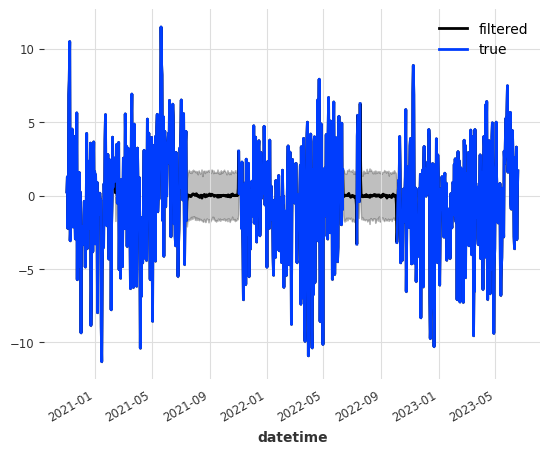

In [9]:
plt.clf()
filtered_covs_dict["eastward_wind"].plot(label="filtered")
covs_dict["eastward_wind"].plot(label="true")
plt.show()

Now below here, I was doing a lot of jumping around, but here on I am forecasting residuals, examining my predictions and modifying the original forecast.

In [78]:
inputs = predictions_filtered-oxy_tseries_filtered
# For covariates here we have [predictions, observed oxygen, air temperature]
covs = predictions_filtered.concatenate(oxy_tseries_filtered, axis=1, ignore_time_axis=True)
covs = covs.concatenate(filtered_covs_dict["air_temperature"], axis=1, ignore_time_axis=True)

val_split = pd.Timestamp(year=2023, month=6, day=18)
training_set, validation_set = inputs.split_before(val_split)

In [26]:
import time
start = time.time()
rnn = BlockRNNModel(model="LSTM",
                    hidden_dim=256,
                    batch_size=8,
                    input_chunk_length=15,
                    output_chunk_length=34,
                    likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
                    optimizer_kwargs={"lr": 1e-4},
                    n_rnn_layers=3,
                    random_state=0)
    
rnn.fit(training_set,
        past_covariates=covs,
        epochs=500, 
        verbose=False)
print(time.time()-start)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=500` reached.


682.7718353271484


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

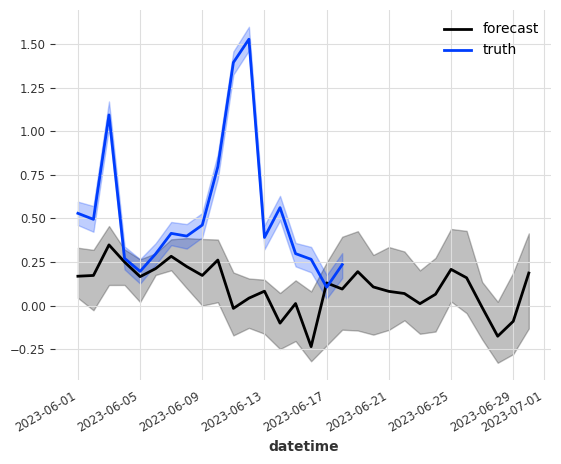

In [27]:
plt.clf()
preds = rnn.predict(n=30,
                    past_covariates=covs, 
                    num_samples=50)
preds.plot(label="forecast")
validation_set.plot(label="truth")
plt.show()

In [80]:
start = time.time()
tcn = TCNModel(input_chunk_length=35,
               output_chunk_length=34,
               likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
               random_state=0)
    
tcn.fit(training_set,
        past_covariates=covs,
        epochs=500, 
        verbose=False)
print(time.time()-start)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=500` reached.


92.09227752685547


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

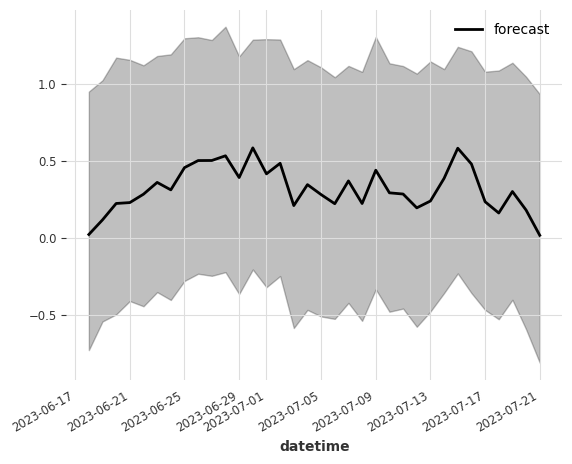

In [81]:
plt.clf()
preds = tcn.predict(n=34,
                    past_covariates=covs, 
                    num_samples=500)
preds.plot(label="forecast")
#validation_set.plot(label="truth")
plt.show()

In [86]:
preds.pd_dataframe().to_csv("predicted_residuals_2023_06_21.csv")

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


In [17]:
val_split = pd.Timestamp(year=2023, month=6, day=1)
_, oxy_val = oxy_tseries_filtered.split_before(val_split)
_, predictions_val = predictions_filtered.split_before(val_split)

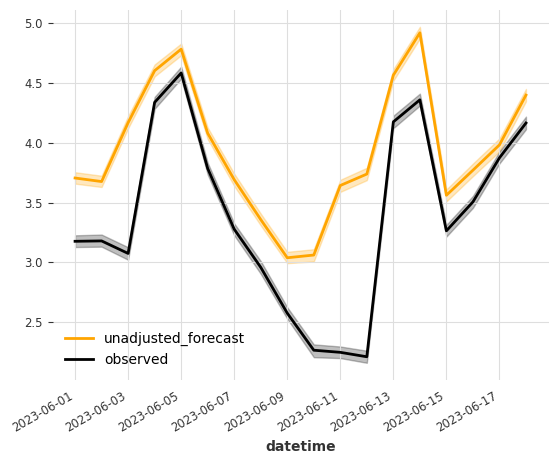

In [60]:
plt.clf()
predictions_val.plot(color="orange", label="unadjusted_forecast")
#(predictions_val-preds[:18]).plot(color="blue", label="adjusted_forecast")
oxy_val.plot(color="black", label="observed")
plt.show()

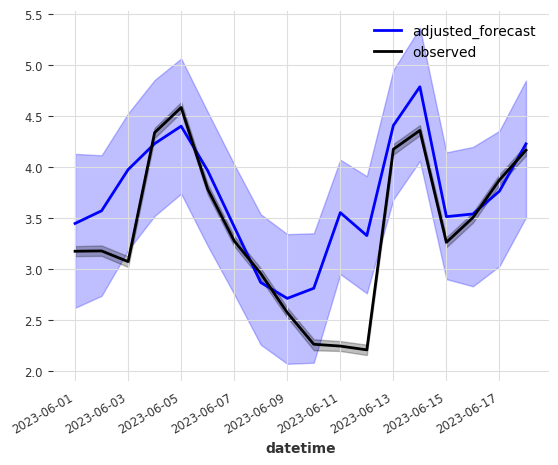

In [61]:
plt.clf()
(predictions_val-preds[:18]).plot(color="blue", label="adjusted_forecast")
oxy_val.plot(color="black", label="observed")
plt.show()

In [8]:
inputs = predictions_filtered-oxy_tseries_filtered
# For covariates here we have [predictions, observed oxygen, air temperature]
covs = predictions_filtered.concatenate(oxy_tseries_filtered, axis=1, ignore_time_axis=True)
covs = covs.concatenate(filtered_covs_dict["air_temperature"], axis=1, ignore_time_axis=True)

val_split = pd.Timestamp(year=2023, month=5, day=1)
training_set, validation_set = inputs.split_before(val_split)

Performing hyperparameter tuning

In [12]:
from optuna.integration import PyTorchLightningPruningCallback
def objective(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # Hyperparameters
    input_chunk_length = trial.suggest_categorical("input_chunk_length", [31, 60, 180, 356])
    kernel_size = trial.suggest_categorical("kernel_size", [2, 3, 5])
    num_filters = trial.suggest_categorical("num_filters", [1, 3, 5])
    num_layers = trial.suggest_categorical("num_layers", [None, 1, 2, 3])
    dilation_base = trial.suggest_categorical("dilation_base", [1, 2, 3])
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2, 0.3])

    tcn_model = TCNModel(input_chunk_length=input_chunk_length,
                    kernel_size=kernel_size,
                    num_filters=num_filters,
                    output_chunk_length=30,
                    likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]))

    tcn_model.fit(training_set,
                  past_covariates=covs,
                  epochs=400, 
                  verbose=False)

    predictions = tcn_model.predict(n=len(validation_set[:30]), 
                                    past_covariates=covs, 
                                    num_samples=50)
    smapes = smape(validation_set[:30], predictions, n_jobs=-1, verbose=False)
    smape_val = np.mean(smapes)

    return smape_val if smape_val != np.nan else float("inf")

In [13]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=100, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
# study.optimize(objective, n_trials=100, callbacks=[print_callback])

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

[I 2023-06-22 19:25:19,527] A new study created in memory with name: no-name-e700fb51-04e3-477a-bd56-6da99e56c254
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:26:32,324] Trial 0 finished with value: 146.40894838776896 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 5, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 0 with value: 146.40894838776896.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 146.40894838776896, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 5, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.2}
Best value: 146.40894838776896, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 5, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:27:39,082] Trial 1 finished with value: 119.64783037049105 and parameters: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 1 with value: 119.64783037049105.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 119.64783037049105, Current params: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 119.64783037049105, Best params: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:28:42,101] Trial 2 finished with value: 163.05910575607479 and parameters: {'input_chunk_length': 31, 'kernel_size': 5, 'num_filters': 5, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 1 with value: 119.64783037049105.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 163.05910575607479, Current params: {'input_chunk_length': 31, 'kernel_size': 5, 'num_filters': 5, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}
Best value: 119.64783037049105, Best params: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:29:51,379] Trial 3 finished with value: 139.60271677772366 and parameters: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 3, 'dropout': 0.1}. Best is trial 1 with value: 119.64783037049105.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 139.60271677772366, Current params: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 3, 'dropout': 0.1}
Best value: 119.64783037049105, Best params: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:30:54,400] Trial 4 finished with value: 143.34480310296013 and parameters: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 1 with value: 119.64783037049105.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 143.34480310296013, Current params: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 119.64783037049105, Best params: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:32:03,115] Trial 5 finished with value: 171.428922387542 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 5, 'num_layers': 1, 'dilation_base': 1, 'dropout': 0.1}. Best is trial 1 with value: 119.64783037049105.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 171.428922387542, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 5, 'num_layers': 1, 'dilation_base': 1, 'dropout': 0.1}
Best value: 119.64783037049105, Best params: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:33:06,561] Trial 6 finished with value: 172.73901942888344 and parameters: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 3, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 1 with value: 119.64783037049105.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 172.73901942888344, Current params: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 3, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.3}
Best value: 119.64783037049105, Best params: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:34:16,402] Trial 7 finished with value: 136.6452734677295 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 3, 'dropout': 0.2}. Best is trial 1 with value: 119.64783037049105.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 136.6452734677295, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 3, 'dropout': 0.2}
Best value: 119.64783037049105, Best params: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:35:27,342] Trial 8 finished with value: 119.10328796189455 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 119.10328796189455, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:36:32,021] Trial 9 finished with value: 145.6207195580331 and parameters: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 2, 'dilation_base': 2, 'dropout': 0.1}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 145.6207195580331, Current params: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 2, 'dilation_base': 2, 'dropout': 0.1}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:37:46,280] Trial 10 finished with value: 133.41423389608636 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 133.41423389608636, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:39:01,946] Trial 11 finished with value: 146.89044719223747 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 146.89044719223747, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:40:13,199] Trial 12 finished with value: 132.3013708780476 and parameters: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 132.3013708780476, Current params: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:41:29,563] Trial 13 finished with value: 142.43549774223013 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 142.43549774223013, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:42:28,669] Trial 14 finished with value: 150.84313116557757 and parameters: {'input_chunk_length': 356, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 150.84313116557757, Current params: {'input_chunk_length': 356, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:43:44,615] Trial 15 finished with value: 138.92311992787265 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 138.92311992787265, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:44:55,851] Trial 16 finished with value: 143.486292846637 and parameters: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 143.486292846637, Current params: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:46:12,020] Trial 17 finished with value: 137.22547728696057 and parameters: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 137.22547728696057, Current params: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:47:23,783] Trial 18 finished with value: 146.99933939342094 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 146.99933939342094, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:48:24,776] Trial 19 finished with value: 161.1631970008092 and parameters: {'input_chunk_length': 356, 'kernel_size': 5, 'num_filters': 5, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.1}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 161.1631970008092, Current params: {'input_chunk_length': 356, 'kernel_size': 5, 'num_filters': 5, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.1}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:49:45,520] Trial 20 finished with value: 149.21016626637055 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 149.21016626637055, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:50:57,663] Trial 21 finished with value: 142.21668154409542 and parameters: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 142.21668154409542, Current params: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:52:06,973] Trial 22 finished with value: 155.86614457152416 and parameters: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 155.86614457152416, Current params: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:53:18,436] Trial 23 finished with value: 138.39288783980282 and parameters: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 138.39288783980282, Current params: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:54:26,501] Trial 24 finished with value: 148.44575263697993 and parameters: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 148.44575263697993, Current params: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:55:43,425] Trial 25 finished with value: 152.2545759425271 and parameters: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 152.2545759425271, Current params: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:57:02,835] Trial 26 finished with value: 139.73881477886246 and parameters: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 139.73881477886246, Current params: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 3, 'dropout': 0.3}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:58:20,010] Trial 27 finished with value: 133.91392792895942 and parameters: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 133.91392792895942, Current params: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 3, 'dropout': 0.3}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:59:27,584] Trial 28 finished with value: 168.74081243582643 and parameters: {'input_chunk_length': 356, 'kernel_size': 5, 'num_filters': 5, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.1}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 168.74081243582643, Current params: {'input_chunk_length': 356, 'kernel_size': 5, 'num_filters': 5, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.1}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:00:39,381] Trial 29 finished with value: 155.3168083395324 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 3, 'num_layers': 2, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 155.3168083395324, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 3, 'num_layers': 2, 'dilation_base': 2, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:01:58,836] Trial 30 finished with value: 152.79853528619876 and parameters: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 5, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 152.79853528619876, Current params: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 5, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:03:14,654] Trial 31 finished with value: 150.5607756394166 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 150.5607756394166, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:04:28,140] Trial 32 finished with value: 124.21789621096828 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 124.21789621096828, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:05:39,626] Trial 33 finished with value: 122.59266488628901 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 122.59266488628901, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:06:52,719] Trial 34 finished with value: 143.9969718571986 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 143.9969718571986, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:08:06,095] Trial 35 finished with value: 144.57437610469356 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 144.57437610469356, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:09:19,189] Trial 36 finished with value: 152.5218068828807 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 5, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 152.5218068828807, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 5, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:10:30,176] Trial 37 finished with value: 132.20238831761267 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 132.20238831761267, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:11:43,683] Trial 38 finished with value: 135.5676233496139 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 135.5676233496139, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.2}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:12:56,266] Trial 39 finished with value: 131.418052122222 and parameters: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 3, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.1}. Best is trial 8 with value: 119.10328796189455.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 131.418052122222, Current params: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 3, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.1}
Best value: 119.10328796189455, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:14:07,441] Trial 40 finished with value: 115.06090781369282 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 115.06090781369282, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:15:15,108] Trial 41 finished with value: 129.92119452916268 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 129.92119452916268, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:16:22,371] Trial 42 finished with value: 130.08413552815276 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 130.08413552815276, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:17:30,130] Trial 43 finished with value: 131.42286773266073 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 131.42286773266073, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:18:38,010] Trial 44 finished with value: 125.92872713480754 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 125.92872713480754, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:19:55,991] Trial 45 finished with value: 134.66079373617075 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 134.66079373617075, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:20:57,154] Trial 46 finished with value: 156.67933509416275 and parameters: {'input_chunk_length': 356, 'kernel_size': 5, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 156.67933509416275, Current params: {'input_chunk_length': 356, 'kernel_size': 5, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:22:07,922] Trial 47 finished with value: 138.48683881283256 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.1}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 138.48683881283256, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.1}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:23:19,094] Trial 48 finished with value: 176.84969973392523 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 5, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 176.84969973392523, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 5, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:24:29,741] Trial 49 finished with value: 168.6913010106045 and parameters: {'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 3, 'num_layers': 2, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 168.6913010106045, Current params: {'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 3, 'num_layers': 2, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:25:44,325] Trial 50 finished with value: 144.4157516008127 and parameters: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 144.4157516008127, Current params: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:26:49,544] Trial 51 finished with value: 147.2850022250269 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 147.2850022250269, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:27:56,775] Trial 52 finished with value: 133.27777584583785 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 133.27777584583785, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:29:06,749] Trial 53 finished with value: 135.79641832265347 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 135.79641832265347, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:30:13,078] Trial 54 finished with value: 140.04420072427283 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 140.04420072427283, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:31:24,498] Trial 55 finished with value: 129.98957331666512 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 129.98957331666512, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:32:37,522] Trial 56 finished with value: 144.44814603213308 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 144.44814603213308, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:33:38,591] Trial 57 finished with value: 132.79615382412 and parameters: {'input_chunk_length': 356, 'kernel_size': 5, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 132.79615382412, Current params: {'input_chunk_length': 356, 'kernel_size': 5, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:34:55,565] Trial 58 finished with value: 126.9755896444116 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 126.9755896444116, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:36:07,525] Trial 59 finished with value: 128.55134574070064 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 128.55134574070064, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:37:28,905] Trial 60 finished with value: 130.37295509511043 and parameters: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 3, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 130.37295509511043, Current params: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 3, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:38:45,500] Trial 61 finished with value: 124.18193685414083 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 124.18193685414083, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:40:03,393] Trial 62 finished with value: 139.154841431813 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 139.154841431813, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:41:20,351] Trial 63 finished with value: 144.50784986629597 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 144.50784986629597, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:42:46,835] Trial 64 finished with value: 138.89850310652733 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 138.89850310652733, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:43:57,928] Trial 65 finished with value: 147.74748230304579 and parameters: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 147.74748230304579, Current params: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:45:10,364] Trial 66 finished with value: 163.5011622292132 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 5, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 163.5011622292132, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 5, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:46:27,226] Trial 67 finished with value: 132.07018323248988 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 132.07018323248988, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:47:33,290] Trial 68 finished with value: 141.0317611449844 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 141.0317611449844, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:48:43,610] Trial 69 finished with value: 129.41442835533368 and parameters: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 129.41442835533368, Current params: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:50:03,212] Trial 70 finished with value: 144.03631213367396 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.1}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 144.03631213367396, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.1}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:51:18,724] Trial 71 finished with value: 133.1344343178618 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 133.1344343178618, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:52:37,885] Trial 72 finished with value: 142.6053434832854 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 142.6053434832854, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:53:58,655] Trial 73 finished with value: 142.697614107862 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 142.697614107862, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:55:17,963] Trial 74 finished with value: 148.6146835069154 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 148.6146835069154, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:56:34,321] Trial 75 finished with value: 145.94930941863498 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 145.94930941863498, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:57:44,245] Trial 76 finished with value: 127.05709796048299 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 127.05709796048299, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:58:50,000] Trial 77 finished with value: 160.55352118465882 and parameters: {'input_chunk_length': 31, 'kernel_size': 5, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 160.55352118465882, Current params: {'input_chunk_length': 31, 'kernel_size': 5, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:00:06,214] Trial 78 finished with value: 173.44099894785103 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 5, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 173.44099894785103, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 5, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:01:23,154] Trial 79 finished with value: 136.56261297126065 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 136.56261297126065, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:02:28,734] Trial 80 finished with value: 154.82519844803028 and parameters: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 154.82519844803028, Current params: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:03:41,672] Trial 81 finished with value: 137.7461051279775 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 137.7461051279775, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:04:53,829] Trial 82 finished with value: 148.01980229029604 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 148.01980229029604, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:06:08,083] Trial 83 finished with value: 139.58991573811267 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 139.58991573811267, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:07:18,400] Trial 84 finished with value: 142.82459169620384 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 142.82459169620384, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:08:27,843] Trial 85 finished with value: 144.0670972625734 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 144.0670972625734, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:09:36,409] Trial 86 finished with value: 157.51260460358858 and parameters: {'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 157.51260460358858, Current params: {'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:10:45,811] Trial 87 finished with value: 129.93770122393653 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 129.93770122393653, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 1, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:11:59,885] Trial 88 finished with value: 150.9087782942117 and parameters: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.1}. Best is trial 40 with value: 115.06090781369282.


Current value: 150.9087782942117, Current params: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.1}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:13:04,425] Trial 89 finished with value: 145.69721772850502 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 145.69721772850502, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:14:16,255] Trial 90 finished with value: 166.23583126097984 and parameters: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 3, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 166.23583126097984, Current params: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 3, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:15:28,049] Trial 91 finished with value: 175.4090893702759 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 175.4090893702759, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:16:40,421] Trial 92 finished with value: 141.29151316765228 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 141.29151316765228, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:17:56,107] Trial 93 finished with value: 139.7069749993365 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 139.7069749993365, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:19:07,276] Trial 94 finished with value: 124.12165838409297 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 124.12165838409297, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:20:18,261] Trial 95 finished with value: 142.906718664235 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 142.906718664235, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:21:35,093] Trial 96 finished with value: 172.33544716929038 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 5, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 172.33544716929038, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 5, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:22:47,074] Trial 97 finished with value: 154.03092281412506 and parameters: {'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 154.03092281412506, Current params: {'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:24:11,861] Trial 98 finished with value: 133.30641703871797 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 133.30641703871797, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:25:25,862] Trial 99 finished with value: 166.5011827716217 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 40 with value: 115.06090781369282.


Current value: 166.5011827716217, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 115.06090781369282, Best params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


In [ ]:
#2023-06-21 for 31 days

In [ ]:
val_split = pd.Timestamp(year=2023, month=6, day=1)
training_set, validation_set = inputs.split_before(val_split)

Now, training a residual forecast model from the best set of hyperparameters found in tuning.

In [15]:
import time
start = time.time()
final_residual_model = TCNModel(input_chunk_length=180,
                                kernel_size=5,
                                num_filters=1,
                                dilation_base=2,
                                output_chunk_length=34,
                                likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
                                random_state=0)
    
final_residual_model.fit(training_set,
                         past_covariates=covs,
                         epochs=400, 
                         verbose=False)
print(time.time()-start)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.


66.16450834274292


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

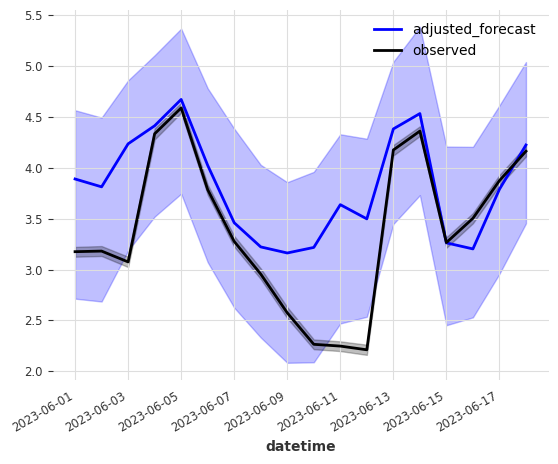

In [18]:
plt.clf()
preds = final_residual_model.predict(n=34,
                                     past_covariates=covs, 
                                     num_samples=500)
(predictions_val-preds[:18]).plot(color="blue", label="adjusted_forecast")
oxy_val.plot(color="black", label="observed")
plt.show()

For comparison here, I plot a tuned TCN model that is trained on the same covariates as the original model and the residual-based method.

In [33]:
df = pd.read_csv("predicted_direct_example.csv")
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((18, 1, -1))
direct_predictions_ts = TimeSeries.from_times_and_values(times, 
                                                         values, 
                                                         fill_missing_dates=True, freq="D")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

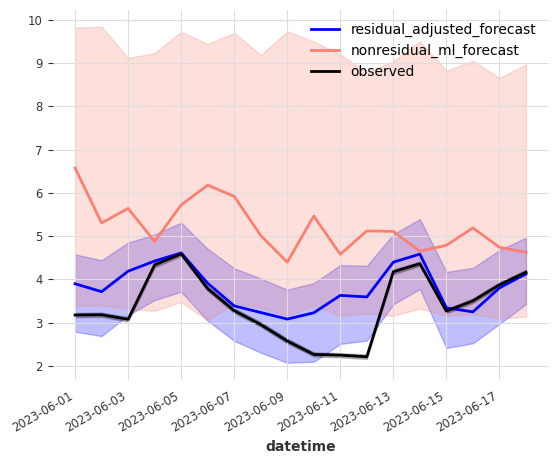

In [39]:
plt.clf()
preds = final_residual_model.predict(n=34,
                                     past_covariates=covs, 
                                     num_samples=500)
(predictions_val-preds[:18]).plot(color="blue", label="residual_adjusted_forecast")
direct_predictions_ts.plot(color="salmon", label="nonresidual_ml_forecast")
oxy_val.plot(color="black", label="observed")
plt.show()
